In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

sn.set_style('whitegrid')
%matplotlib inline

In [3]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [4]:
ten_data = pd.read_csv('./descriptive_stats/tenure_dist.csv')

In [5]:
years_range = ten_data['yd'].unique()
ten_data.head()

,sexo1,edad5,yd,state,wife,husband,mother,mother_5,mother_10,mother_15,...,father_state,hub_state,hub_ten_y,tenure,ten_y,wife_state,wife_ten,disc,part_time,facexp
0,1,20,2005,T,0,0,0,0,0,0,...,NaN,NaN,NaN,1,NaN,NaN,NaN,0,0,11288
1,0,45,2005,P,0,1,0,0,0,0,...,NaN,P,29.916666,359,29.916666,P,48.0,0,0,18044
2,1,45,2005,P,1,0,0,0,0,0,...,NaN,P,29.916666,48,4.000000,P,48.0,0,1,18044
3,1,25,2005,T,0,0,0,0,0,0,...,NaN,P,29.916666,10,NaN,P,48.0,0,0,18044
4,0,55,2005,P,0,0,0,0,0,0,...,NaN,NaN,NaN,387,NaN,NaN,NaN,0,0,17475


In [6]:
path = './plots_hist/'
parent_age_range = np.array([30,35,40])
ten_range = np.arange(0,31,2)
years_sample = years_range[-6:]

T = ten_range.size
Y = years_sample.size

mux = pd.MultiIndex.from_product([parent_age_range,years_sample,['women','men']])
MM = parent_age_range.size * years_sample.size * 2

hist_dict, hist_dict_gross = np.zeros((T-1,MM)), np.zeros((T-1,MM))
hist_dict_w, hist_dict_gross_w = np.zeros((T-1,MM)), np.zeros((T-1,MM))

# hist_dict, hist_dict_gross = pd.DataFrame(), pd.DataFrame()

data_fathers = ten_data[np.logical_and(ten_data['father']==0,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother']==0,ten_data['wife']==1)].copy()

for j,age in enumerate(parent_age_range):
    for i,year in enumerate(years_sample):       

        dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                              np.logical_and(data_mothers['edad5']>=age,
                                                             data_mothers['edad5']<age+5)))]['ten_y'].copy()
        ww = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                              np.logical_and(data_mothers['edad5']>=age,
                                                             data_mothers['edad5']<age+5)))]['facexp'].copy()
        h, b = np.histogram(dta.values,bins=ten_range)
        hist_dict[:,(i*2)+(j*Y*2)],hist_dict_gross[:,(i*2)+(j*Y*2)] = h/np.sum(h), h

        h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
        hist_dict_w[:,(i*2)+(j*Y*2)],hist_dict_gross_w[:,(i*2)+(j*Y*2)] = h/np.sum(h), h


        dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                              np.logical_and(data_fathers['edad5']>=age,
                                                             data_fathers['edad5']<age+5)))]['ten_y'].copy()

        ww = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                              np.logical_and(data_fathers['edad5']>=age,
                                                             data_fathers['edad5']<age+5)))]['facexp'].copy()
        h, b = np.histogram(dta.values,bins=ten_range)
        hist_dict[:,(i*2)+(j*Y*2)+1],hist_dict_gross[:,(i*2)+(j*Y*2)+1] = h/np.sum(h), h

        h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
        hist_dict_w[:,(i*2)+(j*Y*2)+1],hist_dict_gross_w[:,(i*2)+(j*Y*2)+1] = h/np.sum(h), h


hist_dict, hist_dict_gross = pd.DataFrame(hist_dict,columns=mux), pd.DataFrame(hist_dict_gross,columns=mux)
hist_dict_w, hist_dict_gross_w = pd.DataFrame(hist_dict_w,columns=mux),pd.DataFrame(hist_dict_gross_w,columns=mux)

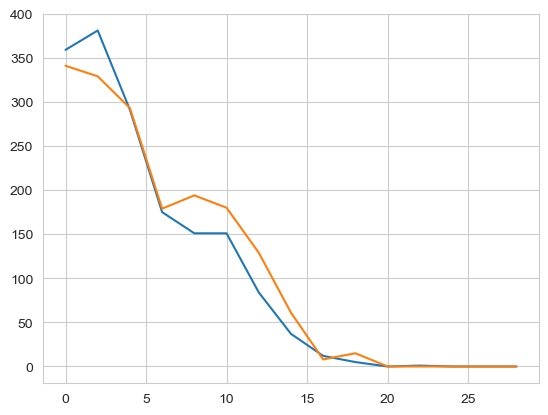

In [9]:
plt.plot(ten_range[:-1],hist_dict_gross[30][2019])
plt.show()

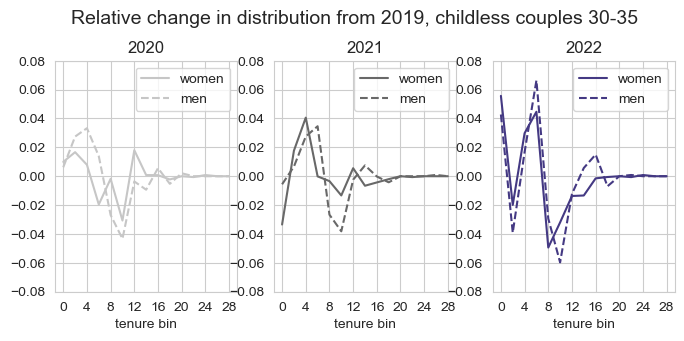

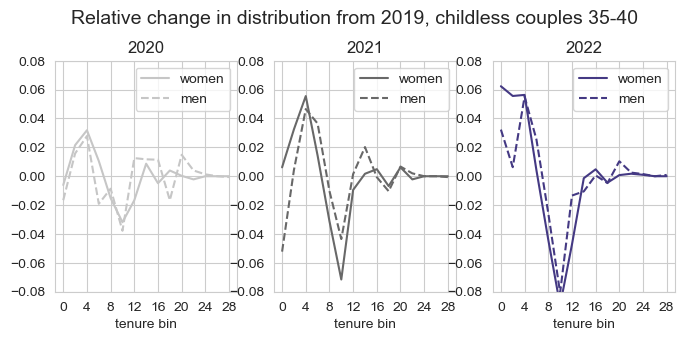

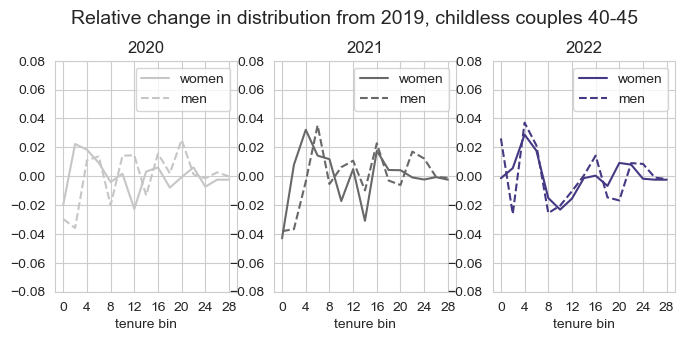

In [11]:
colors = sn.color_palette('Greys',2) + sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for p_age in parent_age_range:
    hist_diff_m = np.zeros((T-1,Y19))
    hist_diff_w = np.zeros((T-1,Y19))
    for i,year in enumerate(years_sample_19):
        hist_diff_w[:,i] = hist_dict[p_age][year]['women']-hist_dict[p_age][2019]['women']
        hist_diff_m[:,i] = hist_dict[p_age][year]['men']-hist_dict[p_age][2019]['men']

    plt.figure(figsize=(8,3))
    name = 'childless couples {}-{}'.format(p_age,p_age+5)
    plt.suptitle('Relative change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
    for i,year in enumerate(years_sample_19):
        plt.subplot(131+i)
        plt.title("{}".format(year))
        plt.plot(ten_range[:-1],hist_diff_w[:,i],c=colors[i],label='women')
        plt.plot(ten_range[:-1],hist_diff_m[:,i],c=colors[i],ls='--',label='men')
        plt.xticks(ten_range[::2])
        plt.xlabel('tenure bin')
        plt.ylim(-0.08,0.08)
        plt.legend()
    plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_relative.pdf',bbox_inches='tight')
    plt.show()

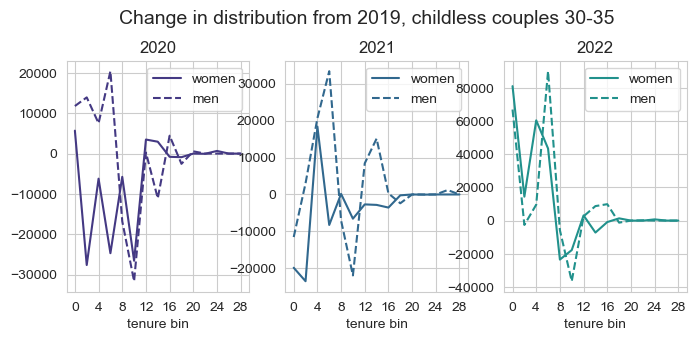

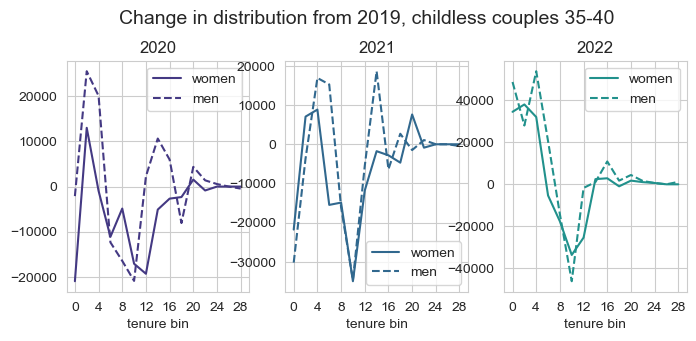

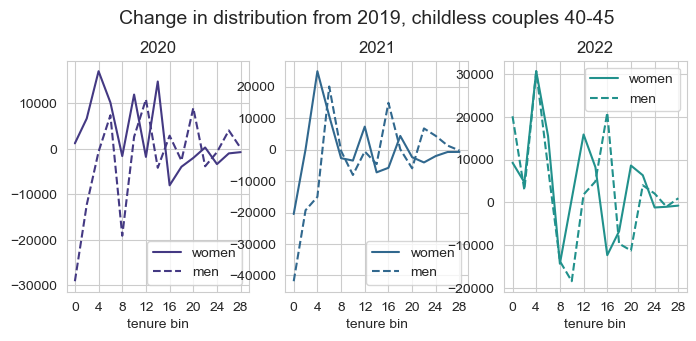

In [12]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size


for p_age in parent_age_range:
    hist_diff_gross_m = np.zeros((T-1,Y19))
    hist_diff_gross_w = np.zeros((T-1,Y19))
    for i,year in enumerate(years_sample_19):
        hist_diff_gross_w[:,i] = hist_dict_gross_w[p_age][year]['women']-hist_dict_gross_w[p_age][2019]['women']
        hist_diff_gross_m[:,i] = hist_dict_gross_w[p_age][year]['men']-hist_dict_gross_w[p_age][2019]['men']

    plt.figure(figsize=(8,3))
    name = 'childless couples {}-{}'.format(p_age,p_age+5)
    plt.suptitle('Change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
    for i,year in enumerate(years_sample_19):
        plt.subplot(131+i)
        plt.title("{}".format(year))
        plt.plot(ten_range[:-1],hist_diff_gross_w[:,i]/100,c=colors[i],label='women')
        plt.plot(ten_range[:-1],hist_diff_gross_m[:,i]/100,c=colors[i],ls='--',label='men')
        plt.xticks(ten_range[::2])
        plt.xlabel('tenure bin')
    #             plt.ylim(-0.05,0.05)
        plt.legend()
    plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_0k.pdf',bbox_inches='tight')
    plt.show()

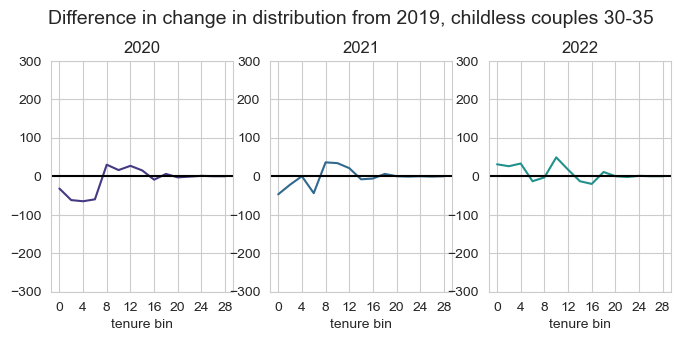

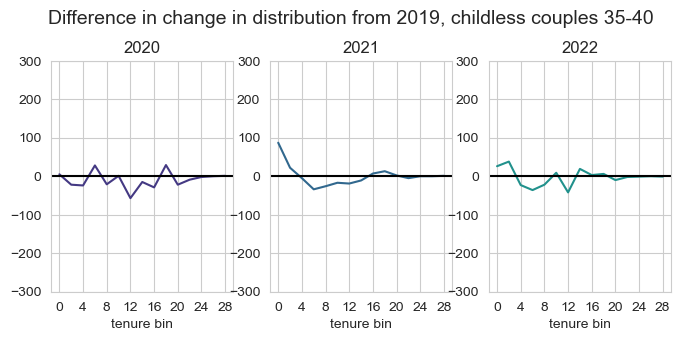

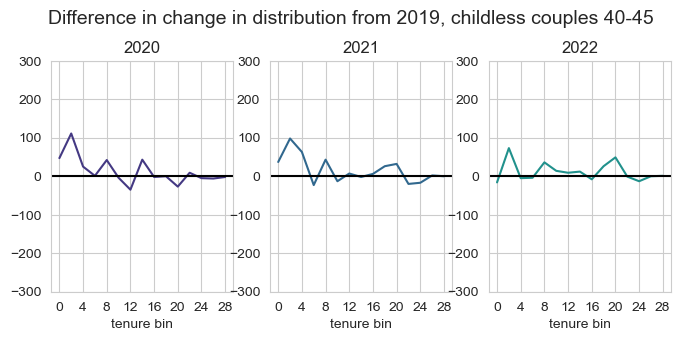

In [15]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size


for p_age in parent_age_range:

    hist_diff_gross_m = np.zeros((T-1,Y19))
    hist_diff_gross_w = np.zeros((T-1,Y19))
    for i,year in enumerate(years_sample_19):
        hist_diff_gross_w[:,i] = hist_dict_gross[p_age][year]['women']-hist_dict_gross[p_age][2019]['women']
        hist_diff_gross_m[:,i] = hist_dict_gross[p_age][year]['men']-hist_dict_gross[p_age][2019]['men']

    plt.figure(figsize=(8,3))
    name = 'childless couples {}-{}'.format(p_age,p_age+5)
    plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
    for i,year in enumerate(years_sample_19):
        plt.subplot(131+i)
        plt.title("{}".format(year))
        plt.plot(ten_range[:-1],hist_diff_gross_w[:,i]-hist_diff_gross_m[:,i],c=colors[i])
        plt.xticks(ten_range[::2])
        plt.xlabel('tenure bin')
        plt.axhline(0,c='k')
        plt.ylim(-300,300)
    plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_both_diff.pdf',bbox_inches='tight')
    plt.show()

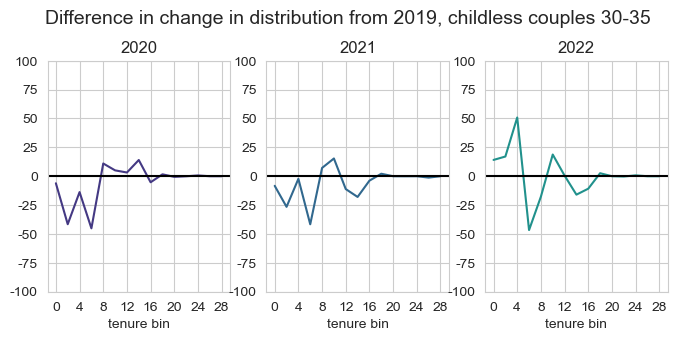

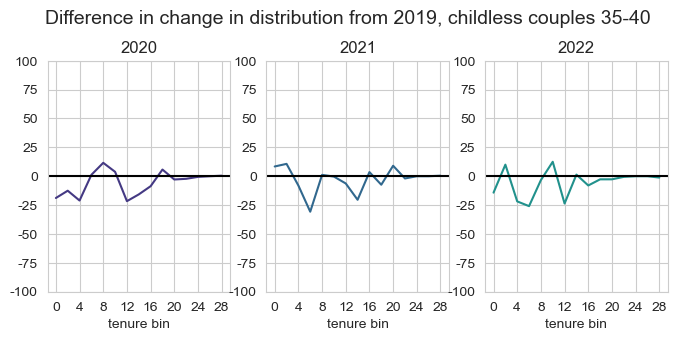

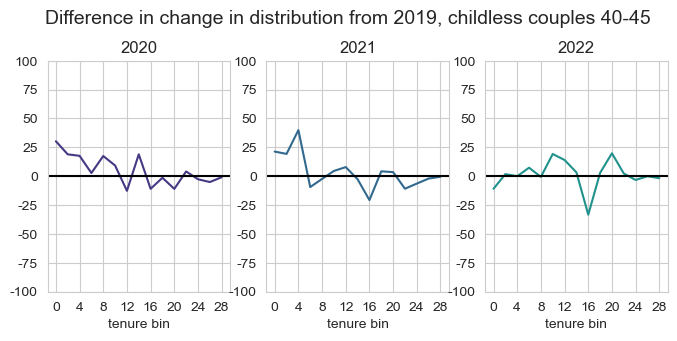

In [17]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for p_age in parent_age_range:

    hist_diff_gross_w_m = np.zeros((T-1,Y19))
    hist_diff_gross_w_w = np.zeros((T-1,Y19))
    for i,year in enumerate(years_sample_19):
        hist_diff_gross_w_w[:,i] = hist_dict_gross_w[p_age][year]['women']-hist_dict_gross_w[p_age][2019]['women']
        hist_diff_gross_w_m[:,i] = hist_dict_gross_w[p_age][year]['men']-hist_dict_gross_w[p_age][2019]['men']

    plt.figure(figsize=(8,3))
    name = 'childless couples {}-{}'.format(p_age,p_age+5)
    plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
    for i,year in enumerate(years_sample_19):
        plt.subplot(131+i)
        plt.title("{}".format(year))
        plt.plot(ten_range[:-1],(hist_diff_gross_w_w[:,i]-hist_diff_gross_w_m[:,i])/100,c=colors[i])
        plt.xticks(ten_range[::2])
        plt.yticks(np.arange(-1e5,1.25e5,2.5e4),np.arange(-100,125,25))
        plt.xlabel('tenure bin')
        plt.axhline(0,c='k')
        plt.ylim(-1e5,1e5)
    plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_both_diff_weighted.pdf',bbox_inches='tight')
    plt.show()

In [ ]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size


    

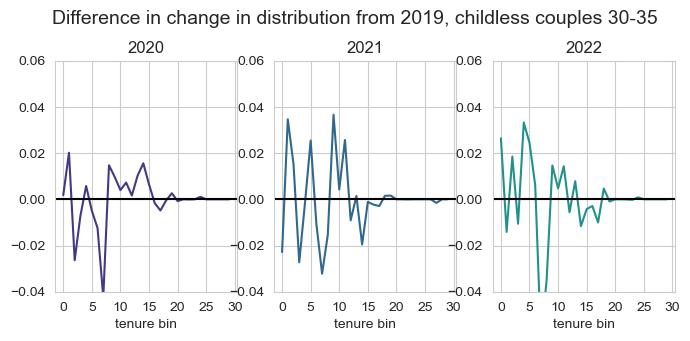

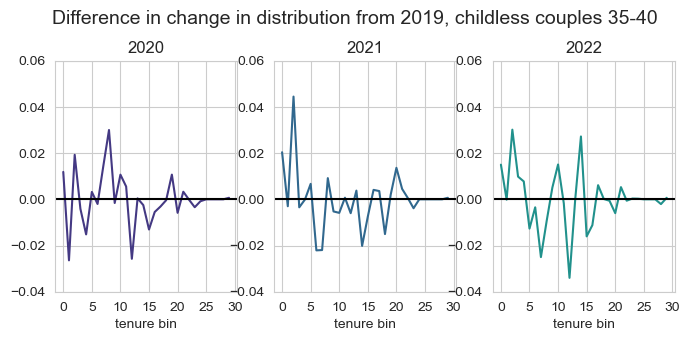

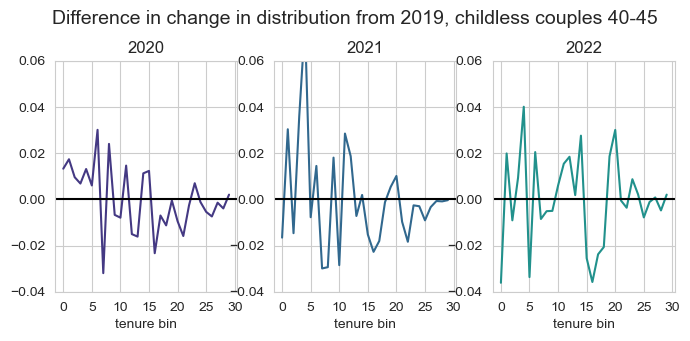

In [52]:
for p_age in parent_age_range:

    hist_diff_w_m = np.zeros((T-1,Y19))
    hist_diff_w_w = np.zeros((T-1,Y19))
    for i,year in enumerate(years_sample_19):
        hist_diff_w_w[:,i] = hist_dict_w[p_age][year]['women']-hist_dict_w[p_age][2019]['women']
        hist_diff_w_m[:,i] = hist_dict_w[p_age][year]['men']-hist_dict_w[p_age][2019]['men']

    plt.figure(figsize=(8,3))
    name = 'childless couples {}-{}'.format(p_age,p_age+5)
    plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
    for i,year in enumerate(years_sample_19):
        plt.subplot(131+i)
        plt.title("{}".format(year))
        plt.plot((hist_diff_w_w[:,i]-hist_diff_w_m[:,i]),c=colors[i])
        plt.xticks(ten_range[::5])
        plt.xlabel('tenure bin')
        plt.axhline(0,c='k')
        plt.ylim(-0.04,0.06)
#             plt.legend()
    plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_both_diff_relative_weighted.pdf',bbox_inches='tight')
    plt.show()

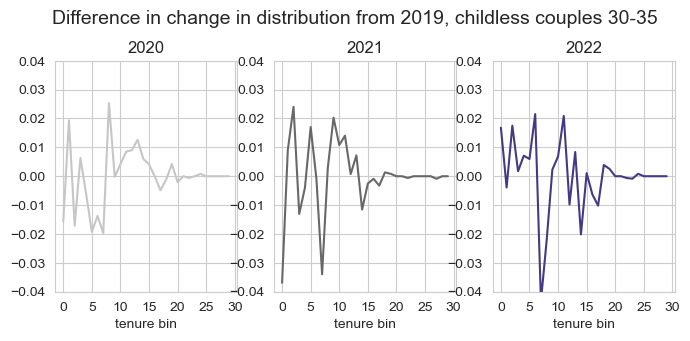

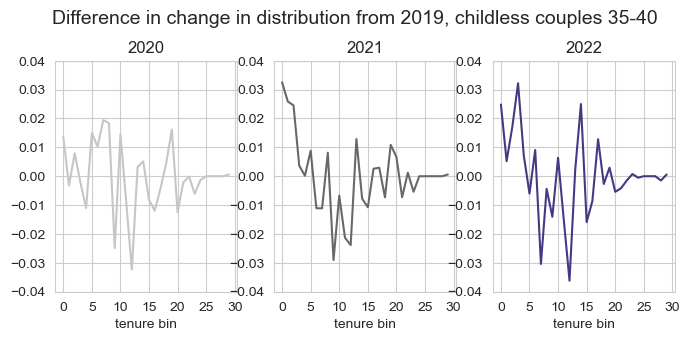

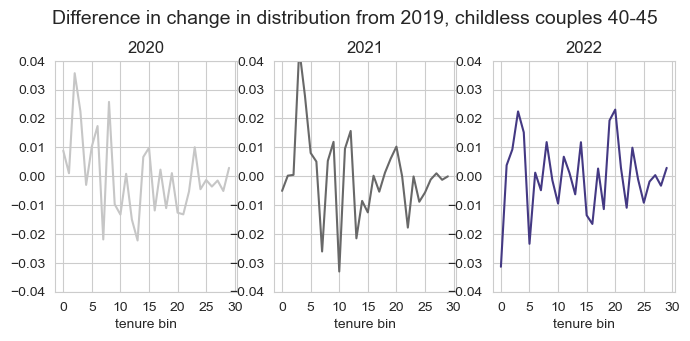

In [54]:
colors = sn.color_palette('Greys',2) + sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size


for p_age in parent_age_range:

    hist_diff_m = np.zeros((T-1,Y19))
    hist_diff_w = np.zeros((T-1,Y19))
    for i,year in enumerate(years_sample_19):
        hist_diff_w[:,i] = hist_dict[p_age][year]['women']-hist_dict[p_age][2019]['women']
        hist_diff_m[:,i] = hist_dict[p_age][year]['men']-hist_dict[p_age][2019]['men']

    plt.figure(figsize=(8,3))
    name = 'childless couples {}-{}'.format(p_age,p_age+5)
    plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
    for i,year in enumerate(years_sample_19):
        plt.subplot(131+i)
        plt.title("{}".format(year))
        plt.plot(hist_diff_w[:,i]-hist_diff_m[:,i],c=colors[i])
        plt.xticks(ten_range[::5])
        plt.xlabel('tenure bin')
        plt.ylim(-0.04,0.04)
#             plt.legend()
    plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_relative both_diff.pdf',bbox_inches='tight')
    plt.show()